In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import numpy as np
import re
import sys

In [2]:
foot_scan = "000700.wrl"

In [3]:
def find_coords(filename):
    holder = []
    with open(filename, "r") as vrml:
        for i, line in enumerate(vrml):
            if i > 16:
                for line in vrml:
                    if line[1] == ']':
                        vrml.close()
                        break
                    else:
                        line = line.strip(',\n')
                        #print(line)
                        new_line = line.split()
                        for j in range(len(new_line)):
                            new_line[j] = float(new_line[j])
                        holder.append(new_line)

                break
    return np.array(holder)
    #print(holder)

In [4]:
def formatting(ax):
    ax.set_xlabel('Width',fontsize = 18 )
    ax.set_ylabel('Length',fontsize = 18)
    ax.tick_params(labelsize=14)
    ax.set_title('Image of footscan ' + str(foot_scan),fontsize = 20)
    return ax

In [5]:
# The following code is a 2D version of the visualiser function in order to
# produce a top down image of a footscan so that the toe line can be evaluated.  

def Visualise2d(scan_array):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(scan_array[:,0],scan_array[:,1],s = 0.9)
    ax = formatting(ax)
    plt.show()

In [6]:
def leftright(scan_array):

    leftside = np.ones(3)

    rightside = np.ones(3)

    for i in range(np.shape(scan_array)[0]):

        if scan_array[i,2] >=0.02:

            rightside = np.vstack((rightside,scan_array[i,:]))

        if scan_array[i,2] <= -0.02:

            leftside = np.vstack((leftside,scan_array[i,:]))



    leftside = np.delete(leftside,0,0)

    rightside = np.delete(rightside,0,0)



    maxleft = np.amax(leftside[:,0])

    maxright = np.amax(rightside[:,0])

    if maxright > maxleft:

        Side = 'L'

    else:

        Side = 'R'
    return Side

In [7]:
# A matrix containing the x and y coordinates for the footscan where 
# the first column is 'width' (x) and the second is 'length' (y).

A = find_coords(foot_scan)
A_2D = []
A_2D = np.c_[A[:, 2], A[:, 0]]
np.shape(A)

(6404L, 3L)

In [8]:
# Whether a foot is left or right is imporant information and this 'foot' value is 
# used throughout.

foot = leftright(A)
foot

'R'

In [9]:
# A convex hull is made of the footscan using a built-in scipy function

C = ConvexHull(A_2D)

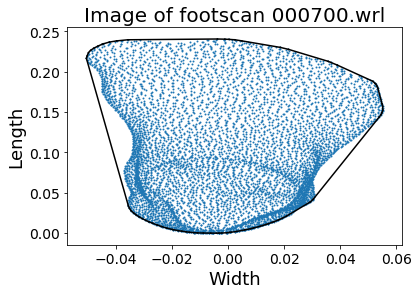

In [10]:
# The following image is a scatter plot of the footscan along with its convex hull which is represented
# by the outer black ring.

Convex_array = []
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(A_2D[:,0],A_2D[:,1],s = 0.9)
ax = formatting(ax)
for simplex in C.simplices:
    Convex_array.append(A_2D[simplex])
    plt.plot(A_2D[simplex, 0], A_2D[simplex, 1], 'k-')

In [11]:
# A 2 dimensional array is made of the convex hull where each row is an x and y coordinate 
# representing a corner for the convex hull. 


Convex = np.zeros((np.shape(Convex_array)[0], np.shape(Convex_array)[1]))
for i in range(len(Convex_array)):
    for j in range(2):
        Convex[i] = Convex_array[i][j]
        
np.shape(Convex)

(77L, 2L)

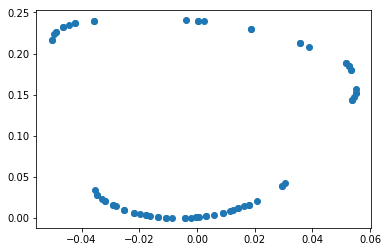

In [12]:
# A scatter plot for the convex array

plt.plot(Convex[:,0], Convex[:,1], 'o')

In [13]:
# Points that are less than 0.16 in the y-coorinate (along with their respective x values)
# are removed since they are not relevant.

A_array = []
for i in range(len(A_2D)):
    if A_2D[i, 1] > 0.16:
        A_array.append(A_2D[i]) 
        
A_new = np.zeros((np.shape(A_array)[0], np.shape(A_array)[1]))
for i in range(len(A_array)):
    A_new[i] = A_array[i]

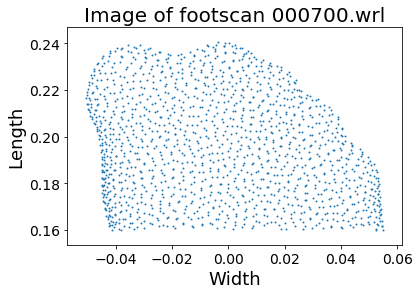

In [14]:
Visualise2d(A_new)

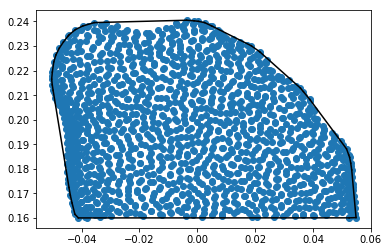

In [15]:
# A new convex hull array is made from the updated foot scan array. The method for 
# creating this convex hull and its array are identical to that shown previously.

C_new = ConvexHull(A_new) 

Convex_array = []
plt.plot(A_new[:,0], A_new[:,1], 'o')
for simplex in C_new.simplices:
    Convex_array.append(A_new[simplex])
    plt.plot(A_new[simplex, 0], A_new[simplex, 1], 'k-')

In [16]:
Convex = np.zeros((np.shape(Convex_array)[0], np.shape(Convex_array)[1]))
for i in range(len(Convex_array)):
    for j in range(2):
        Convex[i] = Convex_array[i][j]

In [17]:
# A new 2D visualiser is made identical to that of the previous function except for 
# the size of the points (they are made bigger in this function).

def Visualise2d_big(scan_array):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(scan_array[:,0],scan_array[:,1])
    ax = formatting(ax)
    plt.show()

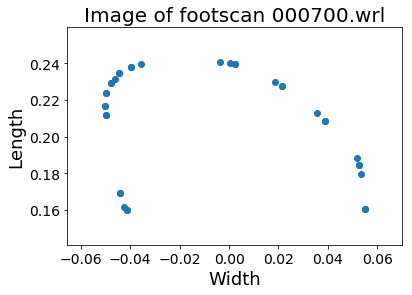

In [18]:
Visualise2d_big(Convex)

In [19]:
# Points of the convex that are less than y = 0.18 are also removed since
# they are irrelevant.

Toe_line_array = []
for i in range (len(Convex)):
    if Convex[i][1] > 0.18:
        Toe_line_array.append(Convex[i])
        
Toe_line = np.zeros((np.shape(Toe_line_array)[0], np.shape(Toe_line_array)[1]))
for i in range(len(Toe_line_array)):
        Toe_line[i] = Toe_line_array[i]

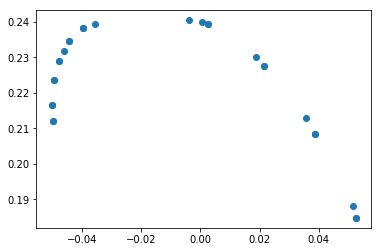

In [20]:
plt.plot(Toe_line[:,0], Toe_line[:,1], 'o')

In [21]:
# The position of the big toe is found by looking for the maximum y-position in a certain range. 
# Since some feet have a longer index toe than big toe, we can't look for the max value
# across the entire range; an index toe is never less than x = -0.01 for a right foot or greater than
# x = 0.01 for a left foot, this is the range implemented.


max_pos = 0
max_value = 0


if foot == 'L':
    for i in range (len(Toe_line)):
        j = Toe_line[i,1]
        if Toe_line[i][1] > max_value and Toe_line[i][0] > 0.01:
            max_value = Toe_line[i][1]
            max_pos = i
            
if foot == 'R':
    for i in range (len(Toe_line)):
        j = Toe_line[i,1]
        if Toe_line[i][1] > max_value and Toe_line[i][0] < -0.01:
            max_value = Toe_line[i][1]
            max_pos = i

In [22]:
# If the big toe is the maximum value across the entire range it is the longest toe, otherwise 
# it can be assumed that the index toe is the longest.


if np.amax(Toe_line[:,1]) == max_value:
    print('The big toe is the longest toe')
else:
    print('The index toe is the longest toe')

The index toe is the longest toe


In [23]:
# We want to remove the convex hull points that make up the side of the big toe since they will
# interfere with the line of best fit. Therefore, any points that are to the left of the big toe position for a
# right foot or to the right for a left foot are removed.


Toe_line_new_array = []

if foot == 'L':
    for i in range(len(Toe_line)):
        if Toe_line[i][0] <= Toe_line[max_pos][0]:
            Toe_line_new_array.append(Toe_line[i])
            
if foot == 'R':
    for i in range(len(Toe_line)):
        if Toe_line[i][0] >= Toe_line[max_pos][0]:
            Toe_line_new_array.append(Toe_line[i])
            
Toe_line_new = np.zeros((np.shape(Toe_line_new_array)[0], np.shape(Toe_line_new_array)[1]))
for i in range(len(Toe_line_new_array)):
        Toe_line_new[i] = Toe_line_new_array[i]

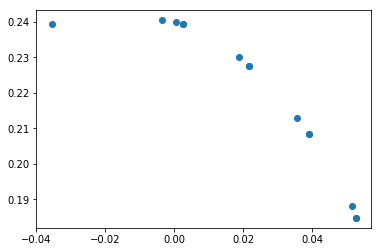

In [24]:
plt.plot(Toe_line_new[:,0], Toe_line_new[:,1], 'o')

In [29]:
"X axis"
x = (Toe_line_new[:,0])

"Y axis"
y = (Toe_line_new[:,1])

In [30]:
X = []
for j in range(len(x) - 1):
    for i in range(len(x) - 1):
        if x[j] == x[i + 1] or x[i] == x[len(x) - 1]:
            X.append(x[i])
        
Y = []
for i in range(len(y) - 1):
    if y[i] != y[i + 1] or y[i] == y[len(y) - 1]:
        Y.append(y[i])
        
        
X = np.matrix(X)
Y = np.matrix(Y)

num_points = np.int(np.shape(X)[1])
k = num_points
n = 1

In [31]:
# The convex hull function produces points that are identical to one another, these need to be removed to keep
# the line of best fit unbiased. A new unique array for both x and y is made that only contains one of each duplicate.


X = []
for i in x:
    if i not in X:
        X.append(i)
        
Y = []
for i in y:
    if i not in Y:
        Y.append(i)

X = np.matrix(X)
Y = np.matrix(Y)

num_points = np.int(np.shape(X)[1])
k = num_points
n = 1

In [32]:
# A new 2D matrix (X_mod) is made where the first column of X_mod is all ones and the second is identical to the vector 'X'.
# Y_mod is simply the tranpose of Y, these opeations are done in order to calculate the least squares variables.

if np.shape(X)[0] == 1:
    X = np.transpose(X)

X_mod = np.c_[np.ones(k), X]

if np.shape(Y)[0] == 1:
    Y_mod = np.transpose(Y)

In [33]:
# This function calculates the coefficients for the linear line of best fit in matrix form. Since it is linear, only two 
# coefficients are calculated (a and b) for the equation y = a + bx.

def least_squares_variables():
    A = []
    j = 0
    A_whole = np.linalg.inv(np.transpose(X_mod) * X_mod) * np.transpose(X_mod) * Y_mod
    A.append(A_whole)
    return A
A = least_squares_variables()

In [34]:
# Once the linear coefficents have been calculated, the predicted y-cooridnates can be easily calculated
# as follows.

"Initial line(s) of best fit"

Y_linear = np.zeros(np.shape(X))
j = 0
i = 0
for i in range(k):
    Y_linear[i] =  np.float(A[j][0]) + np.float(A[j][1]) * X[i]

In [35]:
# The sum squared error is total the difference between the predicted y-values and actual y-value squared (individually).
# This is used to classify whether the overall toe line is curved or straight.

"S = Linear Sum Squared Error"

def SSE():
    S_linear_each = []
    for i in range(k):
        S_i = np.sum(np.square((Y_mod[i] - Y_linear[i])))
        S_linear_each.append(S_i)
    return S_linear_each
SSE_linear = SSE()

In [36]:
# The quadratic coefficients for the 'curve of best fit' are calculated as follows. There are three coefficients (a, b and c)
# for the equation y = a + bx + cx^2.

Y_quadratic = np.zeros(k)

X_quadratic = np.c_[X_mod, np.power(X, 2)]

A_quadratic = []
A_quadratic = np.linalg.inv(np.transpose(X_quadratic) * X_quadratic) * np.transpose(X_quadratic) * Y.transpose()

#for i in range(k):
 #   Y_polynomial[i] =  (np.float(A_polynomial[0]) + np.float(A_polynomial[1]) * X[i] + 
  #                         np.float(A_polynomial[2]) * np.square(X[i]))  + np.float(A_polynomial[3] * np.power(X[i], 3)))

In [37]:
#SSE_polynomial = []
#for i in range(k):
#    S_i = np.square((y[i] - Y_polynomial[i]))
#    SSE_polynomial.append(S_i)   

In [38]:
#Y_ls = np.zeros(k)
#if SSE_polynomial < SSE_linear:
#    for i in range(0, k):
#       Y_ls[i] = Y_polynomial[i]
#else:
#    for i in range(0, k):
#        Y_ls[i] = Y_linear[i]

In [39]:
# A 1D array containing 100 elements evenly spread out from the minimum to the maximum x-cooridinate values is made.
# The quadractic coefficients are then used to create an array for the respective 100 y-coordinates; 100 is chosen 
# in order to create an accurate curve.


X_array = []
i = np.amin(X)
while i < np.amax(X):
    X_array.append(i)
    i = i + (np.amax(X)-np.amin(X))/100
    

Y_quadratic = np.zeros(len(X_array))
for i in range(len(X_array)):
    Y_quadratic[i] =  (np.float(A_quadratic[0]) + np.float(A_quadratic[1]) * X_array[i] +
                           np.float(A_quadratic[2]) * np.square(X_array[i]))

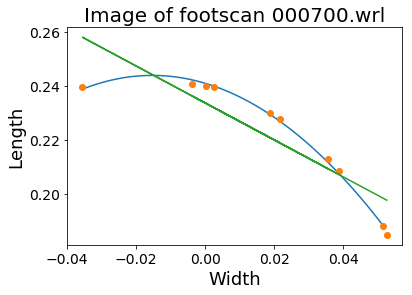

In [40]:
# The following is a scatter plot of the remaining convex hull along with its line and curve of best fit.

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(X_array, Y_quadratic)
plt.plot(X[:], Y_mod[:], 'o')
plt.plot(X[:],Y_linear[:])
ax = formatting(ax)
plt.show()

In [41]:
# The average squared error for each convex hull point to the linear line of best fit is calculated and is 
# the value used to classify the line

Average_lin_error = np.sum(SSE_linear) / len(SSE_linear)

In [42]:
# The gradient of the line of best fit is also calculated and represents the overall steepness of the line.

X = np.array(X)

m = (((np.mean(X)*np.mean(Y_linear)) - np.mean(np.transpose(X)*np.transpose(Y_linear))) /
         ((np.mean(X)**2) - np.mean(Y_linear**2)))

In [43]:
# 7*10^-5 is the boundary used to indicate whether a foot has a straight or curved toe line.

if Average_lin_error <= 7e-05:
    print('The toe line is straight with a gradient of ' + str(m))
    
if Average_lin_error > 7e-05:
    print('The toe line is curved with a gradient of ' + str(m))

The toe line is curved with a gradient of -0.009780608708148909


In [44]:
# The remaining code calculates the gradient from toe to toe.

In [45]:
# The x and y vectors for the convex hull are transposed and then combined to make a 2D array.


if np.shape(Y)[0] == 1:
    Y = np.transpose(Y)
    
if np.shape(X)[0] == 1:
    X = np.transpose(X)
    
XY = np.c_[X, Y]
XY = np.array(XY)

In [46]:
#def selection_sort(x):
 #   for i in range(len(x)):
  #      swap = i + np.argmin(x[i:])
   #     (x[i], x[swap]) = (x[swap], x[i])
    #return x

In [47]:
# The euclidean distances from every point to every other point (including themselves) are calculated in order to combine
# points that represent the same toe.

def Euc_dist(row1, row2, array):
    Euc_dist = np.sqrt(np.square(array[row1][0] - array[row2][0])) + np.sqrt(np.square(array[row1][1] - array[row2][1]))
    return Euc_dist

In [48]:
# This is an (n x n) array where n represents the number of convex hull points of all the euclidean distances.

Euc_dist_total = [[Euc_dist(i, j, XY) for j in range(len(XY))] for i in range(len(XY))]

In [49]:
# This function returns the (latter) index of points that are 'near' each other, two points are considered near each other 
# if their euclidean distance is less than 0.01.

def near(i, j):
    if Euc_dist_total[i][j] < 0.01:
        return j

In [50]:
# This nested list notes down the return values of the 'near' function. It is symmetric by nature since point 1 to point 2 has 
# the same distance as point 2 to point 1. Moreover, the diagonal is always returned since a point always has a distance of
# zero (< 0.01) from itself.

Near_points = [[near(i, j) for j in range(len(XY))] for i in range(len(XY))]

In [51]:
# This function takes the values of the near points list, as long as it exists (i.e. not equal to 'None'), and finds their 
# respective value.

def near_pos(i, j):
    if Near_points[i][j] != None:
        return XY[Near_points[i][j]]

In [52]:
# This is the nested list produced as a result of the near position functioon.

XY_near = [[near_pos(i , j) for j in range(len(XY))] for i in range(len(XY))]

In [71]:
# The following code separates the 'XY_near' nested list into the x and y coordinates and gets rid of the 'None' elements 
# produced by points that are not close enough together.

X_val = []
for i in range(len(XY)):
    X_i = []
    for j in range(len(XY)):
        if type(XY_near[i][j]) == np.ndarray:
            X_i.append(XY_near[i][j][0])
    X_val.append(np.mean(X_i))
    
Y_val = []
for i in range(len(XY)):
    Y_i = []
    for j in range(len(XY)):
        if type(XY_near[i][j]) == np.ndarray:
            Y_i.append(XY_near[i][j][1])
    Y_val.append(np.mean(Y_i))

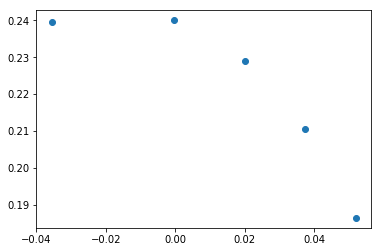

In [81]:
# Since the euclidean distance function returns the distance from point 1 to point 2 and point 2 to point 1 if
# they are close enough, twice as many values are included as they should be. 
# The following code ignores all but one of these duplicates so that the remaining lists are unique. 

X_toe_point = []
for i in X_val:
    if i not in X_toe_point:
        X_toe_point.append(i)
        
Y_toe_point = []
for i in Y_val:
    if i not in Y_toe_point:
        Y_toe_point.append(i)
        
        
# Scatter plot of the clustered convex hull points. Ideally, there are five points (one for each toe). 

plt.plot(X_toe_point[:], Y_toe_point[:], 'o')

In [83]:
XY_toe_point = np.c_[np.ones(5), np.zeros(5)]

X_toe_point = []
for i in X_val:
    if i not in X_toe_point:
        X_toe_point.append(i)
        
Y_toe_point = []
for i in Y_val:
    if i not in Y_toe_point:
        Y_toe_point.append(i)

        
# If one too many convex hull points still remain, this if loop finds which two points are the closest (smallest euclidean
# distance). These two points are then combined by finding the mean of their x and y values to leave five remaining points.
if len(X_toe_point) == 6:
    New_XY = np.c_[X_toe_point, Y_toe_point]
    New_Euc_dist_total = [[Euc_dist(i, j, New_XY) for j in range(len(New_XY))] for i in range(len(New_XY))]
    for i in range(len(New_Euc_dist_total)):
        for j in range(len(New_Euc_dist_total)):
            if New_Euc_dist_total[i][j] == 0:
                New_Euc_dist_total[i][j] = 100

    closest = 100
    for i in range(len(New_Euc_dist_total)):
        if np.amin(New_Euc_dist_total[i]) < closest:
            closest = np.amin(New_Euc_dist_total[i])
            closest_idx_1 = np.argmin(New_Euc_dist_total[i])
            closest_idx_0 = i

    New_XY_2 = np.c_[np.ones(len(X_toe_point)), np.ones(len(X_toe_point))]
    j = 0
    for i in range(len(X_toe_point)):
        if i != closest_idx_1 and i != closest_idx_0:
            New_XY_2[i][0] = X_toe_point[i]
            New_XY_2[i][1] = Y_toe_point[i]
            j = j + 1

    New_XY_2[closest_idx_0][0] = (X_toe_point[closest_idx_0] + X_toe_point[closest_idx_1])/2
    New_XY_2[closest_idx_0][1] = (Y_toe_point[closest_idx_0] + Y_toe_point[closest_idx_1])/2

    New_X_toe_point = []
    New_Y_toe_point = []
    for i in range(len(New_XY_2)):
        New_X_toe_point.append(New_XY_2[i][0])
        New_Y_toe_point.append(New_XY_2[i][1])

    New_X_toe_point.remove(1)
    New_Y_toe_point.remove(1)

    New_XY = np.c_[New_X_toe_point, New_Y_toe_point]
    X_toe_point = New_X_toe_point
    Y_toe_point = New_Y_toe_point
    

# This for loop combines the x and y points and rearranges them from smallest to largest x-cooridinate value 
# (along with the respective y-coordinate).  
for i in range(len(X_toe_point)):
    XY_toe_point[i][0] = np.amin(X_toe_point)
    XY_toe_point[i][1] = Y_toe_point[np.argmin(X_toe_point)]
    X_toe_point[np.argmin(X_toe_point)] = 100
    

    
# If there are one too few convex hull points remaining, the two points that are farthest apart (largest euclidean distance)
# are found so that a new point can be made. This new point is the average of the two in the x direction which is then plugged
# into the curve of best fit equation to produce a y coordinate.  
if len(X_toe_point) == 4:
    gap = []
    for i in range(3):
        gap.append(Euc_dist(i, i+1, XY_toe_point))
    if np.argmax(gap) == 0:
        idx = [0, 4, 1, 2, 3]
        XY_toe_point = XY_toe_point[idx]
    if np.argmax(gap) == 1:
        idx = [0, 1, 4, 2, 3]
        XY_toe_point = XY_toe_point[idx]
    if np.argmax(gap) == 2:
        idx = [0, 1, 2, 4, 3]
        XY_toe_point = XY_toe_point[idx]
    j = np.argmax(gap) + 1
    x_i = (XY_toe_point[j-1][0] + XY_toe_point[j+1][0])/2
    XY_toe_point[j][0] = x_i
    XY_toe_point[j][1] =  (np.float(A_quadratic[0]) + np.float(A_quadratic[1]) * x_i +
                           np.float(A_quadratic[2]) * np.square(x_i))

In [84]:
XY_toe_point

array([[-0.035601  ,  0.23955   ],
       [-0.00029367,  0.24003767],
       [ 0.0201095 ,  0.228885  ],
       [ 0.0372675 ,  0.2105655 ],
       [ 0.052109  ,  0.1864275 ]])

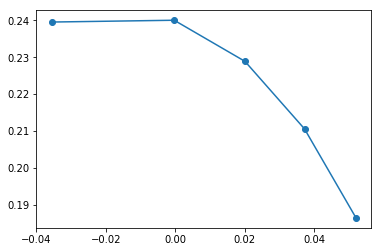

In [85]:
plt.plot(XY_toe_point[:, 0], XY_toe_point[:, 1], 'o-')

In [63]:
# Simple function to find the slope between two to points. 

def slope(x1, x2, y1, y2):
    return (y2-y1)/(x2-x1)

In [86]:
# This nested list represents the four gradients from one point to the next. 

m_toe2toe = [[slope(XY_toe_point[i][0], XY_toe_point[i+1][0], XY_toe_point[i][1], XY_toe_point[i+1][1])] for i in 
             range(len(XY_toe_point)-1)]
m_toe2toe

[[0.013812050376692206],
 [-0.5466144961157992],
 [-1.0676943699731902],
 [-1.6263854731664575]]

In [65]:
# The four gradients are seperated into four different values. If a foot is a left, the elements of 
# the list are flipped and a minus sign is added so that the gradients go from the big toe to the little 
# and positive and negative gradients represent an increase and decrease respecively for both feet. 
# No change needs to be done to a right foot.

if foot == 'L':
    m_1 = - m_toe2toe[3][0]
    m_2 = - m_toe2toe[2][0]
    m_3 = - m_toe2toe[1][0]
    m_4 = - m_toe2toe[0][0]
    
if foot == 'R':
    m_1 = m_toe2toe[0][0]
    m_2 = m_toe2toe[1][0]
    m_3 = m_toe2toe[2][0]
    m_4 = m_toe2toe[3][0]

In [87]:
# This writes the gradient values into words.

Gradient = [m_1, m_2, m_3, m_4]
Change = [0, 0, 0, 0]
for i in range(len(Gradient)):
    if Gradient[i] < 0.1 and Gradient[i] > -0.1:
        Change[i] = 'Horizontal'
    if Gradient[i] > 0.1 and Gradient[i] < 0.5:
        Change[i] = 'Shallow Increase'
    if Gradient[i] < -0.1 and Gradient[i] > -0.5:
        Change[i] = 'Shallow Decrease'
    if Gradient[i] > 0.5:
        Change[i] = 'Sharp Increase'
    if Gradient[i] < -0.5:
        Change[i] = 'Sharp Decrease'
        
Change

['Horizontal', 'Sharp Decrease', 'Sharp Decrease', 'Sharp Decrease']